In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

cwd = Path.cwd()
ROOT_PATH = str(cwd.parent.parent.parent.parent)
sys.path.append(ROOT_PATH)
from simpml.tabular.all import *
from simpml.vision.all import *
%matplotlib inline

# Vision Use Cases

## Binary Classification

### Standard Trainer

#### Data Manager

We are going to use the FastAI library to set up a data manager for image classification tasks.

We start by importing the necessary modules from the FastAI library, which is a high-level library built on top of PyTorch.

Next, we create a VisionDataManager object to manage the data pipeline for a binary classification task. To do this, we use the ImageDataLoaders.from_name_func method to load the images from the PETS dataset, which can be downloaded using the untar_data function with the URLs.PETS argument.

The from_name_func method takes three arguments:

1. The path to the dataset, which is obtained by untarring the PETS dataset.
2. A list of image files, retrieved using the get_image_files function.
3. A function that serves as a label extractor. In this case, we use a lambda function that checks if the first character of the file name is uppercase. If it is, the image is considered to belong to class 1, and if not, it belongs to class 0.

Additionally, we apply an image transformation to resize all images to 224x224 pixels using the Resize(224) method.

Finally, we specify the prediction_type and data_type as binary classification and vision, respectively, to properly configure the VisionDataManager.

This data manager can now be used to train and evaluate a binary image classification model using the FastAI library.

In [2]:
def is_first_char_upper(f): return f[0].isupper()

data_manager = VisionDataManager(ImageDataLoaders.from_name_func(
    untar_data(URLs.PETS),
    get_image_files(untar_data(URLs.PETS)/"images"),
    is_first_char_upper, 
    item_tfms=Resize(224)),
    prediction_type = PredictionType.BinaryClassification.value,
    data_type = DataType.Vision.value
)

We are going to visualize a batch of images from the dataset using the FastAI library. 

We have already set up the data manager in the previous snippet, which handles the data pipeline for a binary classification task using the PETS dataset.

To display a batch of images along with their labels, we use the show_batch() method of the DataLoaders object stored in the data_manager under the dls attribute. 

This method generates a grid of images, showing a random sample of images from the dataset along with their corresponding labels. This helps to get a better understanding of the dataset's content and its distribution among the two classes.

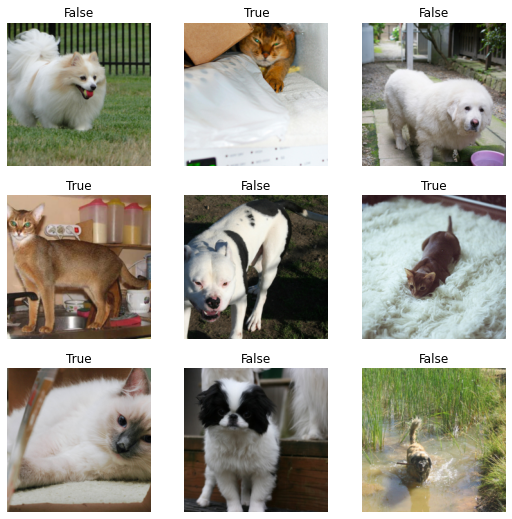

In [3]:
data_manager.dls.show_batch()

#### Experiment Manager

We are going to create an ExperimentManager object that will help us manage the training and evaluation process. 

The ExperimentManager class provides a convenient way to handle the modeling, training, and evaluation of experiments, making the workflow easier to manage.

In this case, we will use the Area Under the Receiver Operating Characteristic curve (AUC) as the evaluation metric, which is a popular choice for binary classification tasks.

We then create the ExperimentManager object, passing in the data_manager we have set up previously and the desired evaluation metric MetricName.AUC. This exp_mang object can now be used to configure, train, and evaluate models.

In [4]:
exp_mang = ExperimentManager(data_manager, MetricName.AUC)

In [5]:
exp_mang.display_models_pool()

,Name,Description,Source,Is Available
0,Resnet-34,Resnet-34 Pretrained Model ImageNet,Pool,True
1,Resnet-18,Resnet-18 Pretrained Model ImageNet,Pool,True
2,Resnet-50,Resnet-50 Pretrained Model ImageNet,Pool,True
3,Random Baseline Classification,Default settings,Pool,True
4,Naive Baseline Classification,Default settings,Pool,True


In [6]:
exp_mang.display_metrics_pool()

,Name,Description,Source,Is Available,Is Optimal
0,AUC,,Pool,True,True
1,F1,,Pool,True,False
2,Recall,,Pool,True,False
3,Precision,,Pool,True,False
4,BalancedAccuracy,,Pool,True,False
5,Accuracy,,Pool,True,False


##### Let's examine the models available for this type of problem

We are going to access the models_pool property of the ExperimentManager (exp_mang) object. The models_pool attribute is a list containing all available for training for the defined problem type and data

In order not to occupy too much GPU RAM, we will use the save_models_to_disk flag and provide the class with two functions:
- empty_cache_func
- load_checkpoints_func

So that the department knows how to load into memory models saved with the help of export and you can clean the memory efficiently.ExperimentManager

In [7]:
exp_mang = ExperimentManager(data_manager,
                             MetricName.AUC, 
                             save_models_to_disk = True, 
                             load_checkpoints_func = load_fastai_model, 
                             empty_cache_func = empty_torch_cache,
                        )
#exp_mang.run_experiment(models_kwargs={'num_epocs': 5})

,Experiment ID,Model,Description,Data Version,Data Description,Model Params,Metric Params,Accuracy,AUC,Recall,Precision,BalancedAccuracy,F1,Run Time
0,e7c72da9,Random Baseline Classification,Default settings,01028de4,,{'num_epocs': 5},{},0.565629,0.498684,0.300000,0.329596,0.498684,0.314103,0:00:19
1,e7c72da9,Naive Baseline Classification,Default settings,01028de4,,{'num_epocs': 5},{},0.700271,0.570590,0.185714,0.674074,0.570590,0.291200,0:00:37
2,e7c72da9,Resnet-50,Resnet-50 Pretrained Model ImageNet,01028de4,,{'num_epocs': 5},{},0.997294,0.995918,0.991837,1.000000,0.995918,0.995902,0:02:51
3,e7c72da9,Resnet-34,Resnet-34 Pretrained Model ImageNet,01028de4,,{'num_epocs': 5},{},0.997294,0.997976,1.000000,0.991903,0.997976,0.995935,0:01:51
4,e7c72da9,Resnet-18,Resnet-18 Pretrained Model ImageNet,01028de4,,{'num_epocs': 5},{},0.997970,0.997967,0.997959,0.995927,0.997967,0.996942,0:01:29


By calling exp_mang.models_pool, we retrieve a list that includes a brief description of each model along with the actual model object (for FastAI-based models, these are Learner objects).

The list shows that the experiment manager initialized five different models for us:

- Random Baseline Classification (default settings)
- Naive Baseline Classification (default settings)
- Resnet-18 (pretrained on ImageNet)
- Resnet-34 (pretrained on ImageNet)
- Resnet-50 (pretrained on ImageNet)

With this list, we can easily access any of the trained models for further analysis, fine-tuning, or deployment.

In this code snippet, we are going to use the ExperimentManager object created earlier to train and evaluate a suite of machine learning models with the simpml library. The fit_suite method is a convenient way to train multiple models using the same dataset, allowing us to compare their performance on the specified evaluation metric(s).

We call the fit_suite method on the exp_mang object and pass a dictionary containing the keyword argument 'num_epochs': 5 to set the number of training epochs for each model. The fit_suite method will then train and evaluate each model in the suite using the data provided by the data_manager and the evaluation metric specified during the creation of the ExperimentManager object, which in this case is the AUC.

Once the training and evaluation process is complete, the fit_suite method returns a summary of the results in a tabular format. This summary includes information such as the Run ID, model description, data version, model parameters, evaluation metric values (e.g., accuracy, AUC, recall, precision, balanced accuracy, and F1 score), and run time for each model. By reviewing this summary, we can easily compare the performance of different models and choose the one that best fits our requirements.

In this code snippet, we are going to use the ExperimentManager object (exp_mang) to find and retrieve the best model from the pool of trained models, based on the evaluation metric specified earlier (AUC in this case).\

We call the get_best_model() method on the exp_mang object to find the model with the highest performance on the specified evaluation metric. The method returns the best model as a Learner object (for FastAI-based models) along with its description.

In [11]:
#best_model = exp_mang.get_best_model()

 In this example, the best model is the Resnet-34 pretrained on ImageNet. Once we have identified the best model, we can use it for further analysis, fine-tuning, or deployment.

#### Interpreter

In [21]:
#interp = ClassificationInterpretation.from_learner(best_model.model)

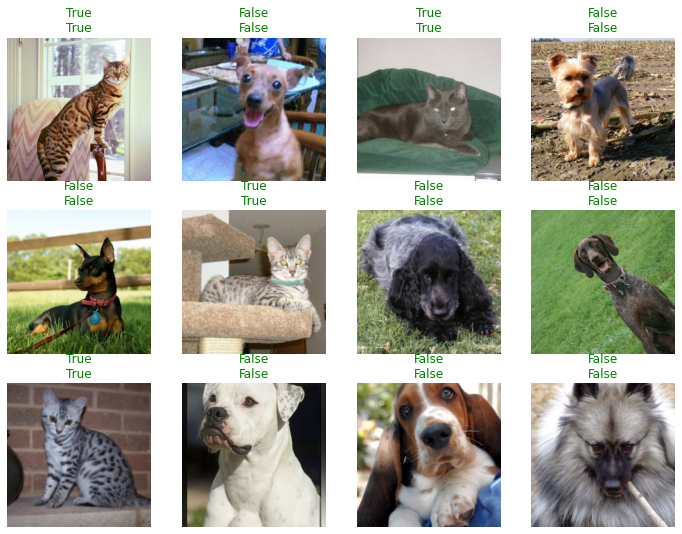

In [27]:
#interp.show_results(list(range(12)))

In [30]:
#interp.print_classification_report()

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       988
        True       0.99      1.00      1.00       490

    accuracy                           1.00      1478
   macro avg       1.00      1.00      1.00      1478
weighted avg       1.00      1.00      1.00      1478



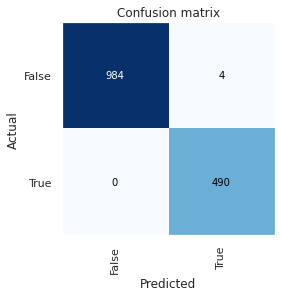

In [28]:
#interp.plot_confusion_matrix()

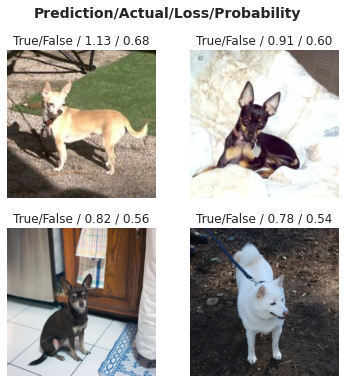

In [29]:
#interp.plot_top_losses(4)

### Cross-Validation

#### data_manager

untar_data(URLs.PETS)In this section, we extend our model evaluation process by incorporating cross-validation. We've already covered the basics of model building, optimization, and performance comparison. Now, let's add a layer of robustness to our assessments with cross-validation.

Cross-validation is a powerful technique that helps prevent overfitting to a specific data distribution, ensuring our model selection is more reliable.

In [41]:
def is_first_char_upper(f):
    # Convert PosixPath to string and then check if the first character is uppercase
    return str(f).split('/')[-1][0].isupper()

data_manager = CrossValidationVisionDataManager(
                    dls = ImageDataLoaders.from_name_func(
                        untar_data(URLs.PETS),
                        get_image_files(untar_data(URLs.PETS)/"images"),
                        is_first_char_upper, 
                        item_tfms=Resize(224)),
                    cross_validation_splitter = FastaiCrossValidationSplitterAdapter(get_y=is_first_char_upper, n_folds=5),
                    prediction_type = PredictionType.BinaryClassification.value,
                    data_type = DataType.Vision.value
                )

In [51]:
len(data_manager.dls_folds_list)

5

#### Experiment Manager

Now we can train models using a cross-validation technique.
We will use exactly the same code as before, but we will add a variable for trainer and initialize a variable that is suitable for cross validation

In [47]:
exp_mang = ExperimentManager(data_manager,
                             MetricName.AUC, 
                             save_models_to_disk = True, 
                             load_checkpoints_func = load_fastai_model, 
                             empty_cache_func = empty_torch_cache,
                             trainer = CVTrainer(aggregation = CVAggregation.MEAN, selected_model = CVSelectedModel.BEST)
                        )

In our CVTrainer, we are specifying two critical parameters:

aggregation: This parameter determines how to combine the performance metrics across the different folds. We can choose between 'mean', 'max', or 'min'. Here we've selected 'mean', which means the performance metrics in our results table will be the average performance across all folds.

selected_model: This parameter controls which model instance is returned from the cross-validation folds. It could either be the 'best' or the 'worst' performing model.

Once our experiment manager is defined, we can execute the experiment. Now, each model is not just trained and evaluated once, but across different distributions of the data.

In [49]:
#exp_mang.run_experiment(models_kwargs={'num_epocs': 5})

,Experiment ID,Model,Description,Data Version,Data Description,Model Params,Metric Params,Accuracy,AUC,Recall,Precision,BalancedAccuracy,F1,Run Time
0,d3c3507a,Random Baseline Classification,Default settings,ff676775,,{'num_epocs': 5},{},0.561429,0.501560,0.329870,0.327933,0.501560,0.328834,0:01:06
1,d3c3507a,Naive Baseline Classification,Default settings,ff676775,,{'num_epocs': 5},{},0.693590,0.559430,0.174675,0.596167,0.559430,0.269447,0:02:11
2,d3c3507a,Resnet-50,Resnet-50 Pretrained Model ImageNet,ff676775,,{'num_epocs': 5},{},0.997674,0.996932,0.994805,0.998058,0.996932,0.996418,0:10:30
3,d3c3507a,Resnet-34,Resnet-34 Pretrained Model ImageNet,ff676775,,{'num_epocs': 5},{},0.995347,0.994368,0.991558,0.994156,0.994368,0.992844,0:07:02
4,d3c3507a,Resnet-18,Resnet-18 Pretrained Model ImageNet,ff676775,,{'num_epocs': 5},{},0.993233,0.992129,0.988961,0.990293,0.992129,0.989608,0:06:05


The table we see shows the indices according to the aggregation we chose earlier (average, in this case).
To go a little deeper and compare performance between the different folds, we can use the plots that the trainer creates for us:

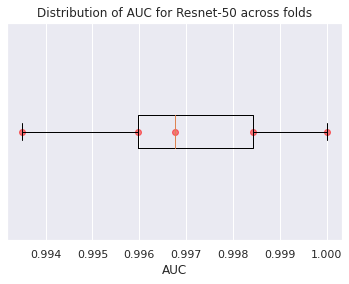

In [53]:
#_ = exp_mang.trainer.box_plot_per_model_and_metric('Resnet-50', 'AUC')

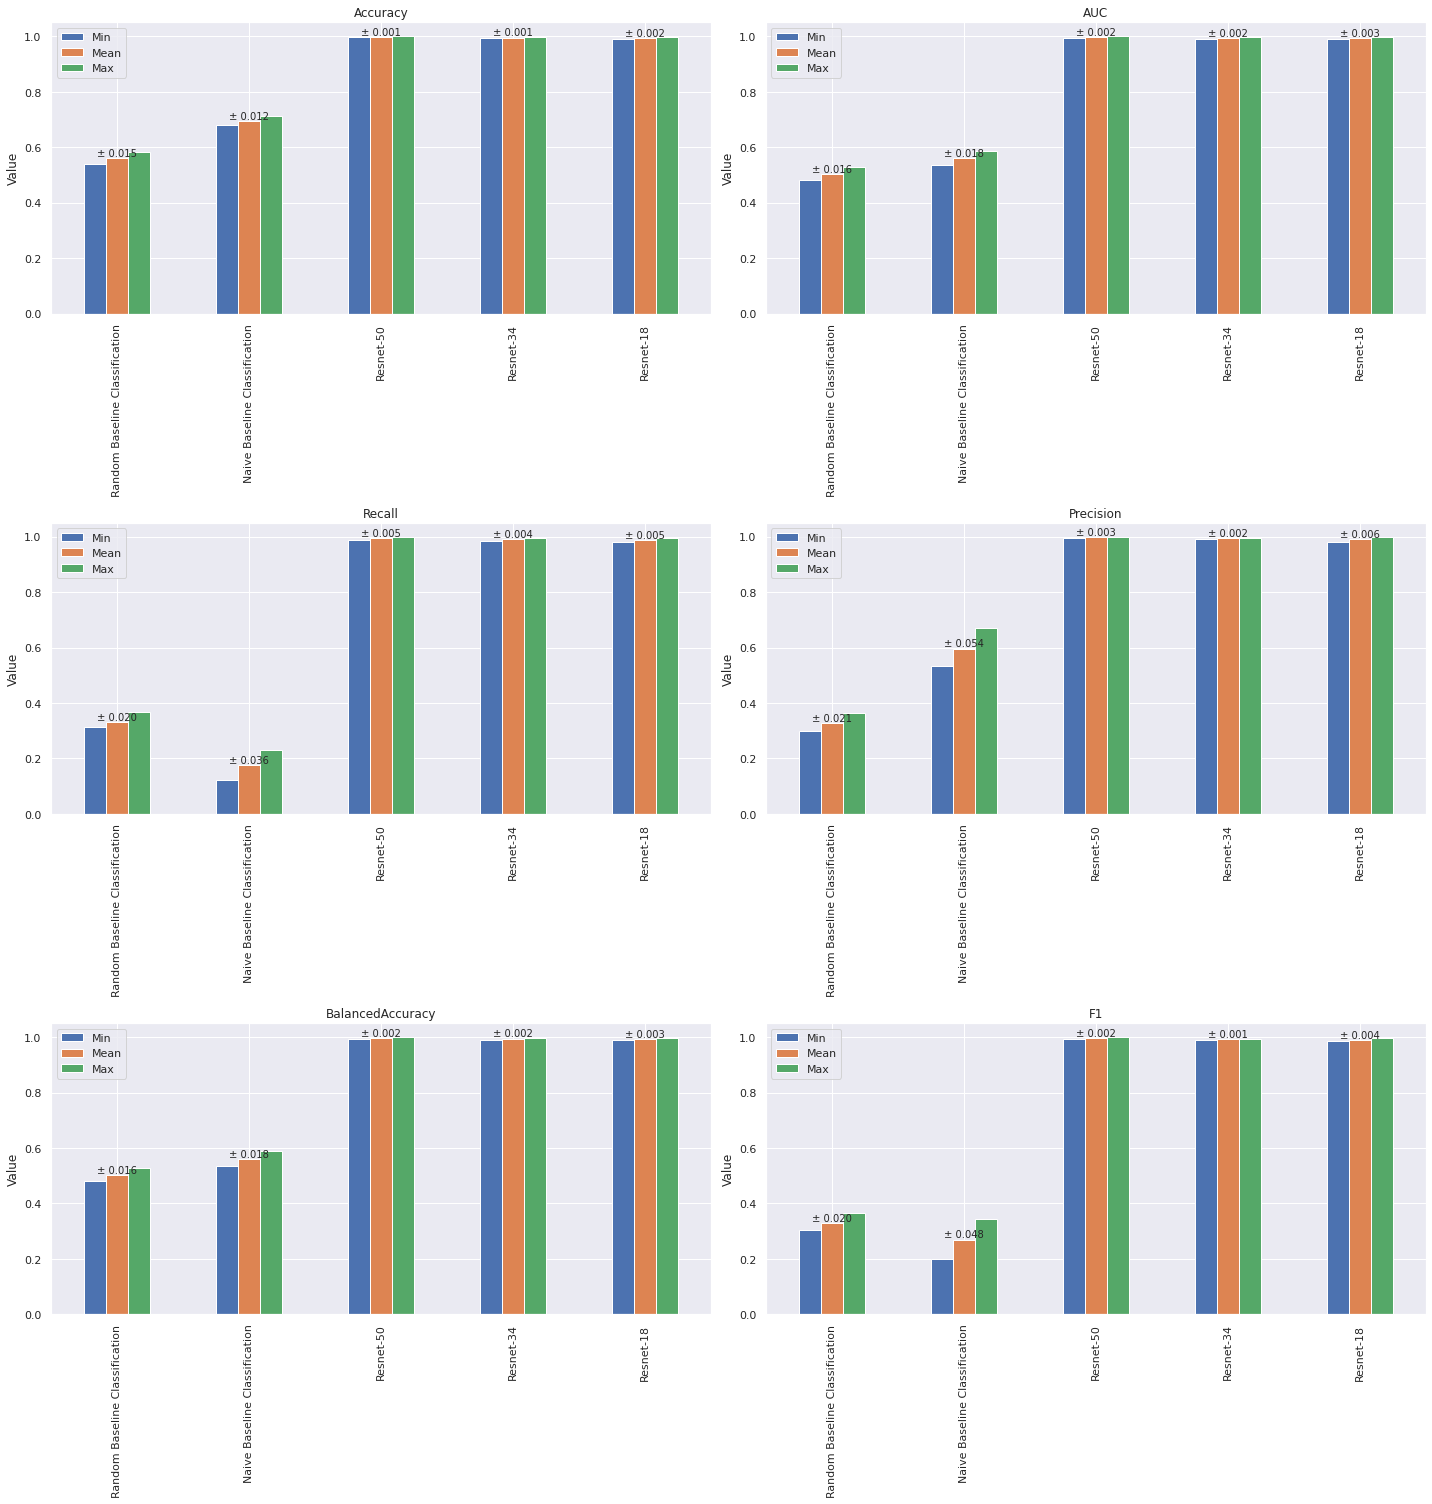

In [55]:
#_ = exp_mang.trainer.plot_cv_res()

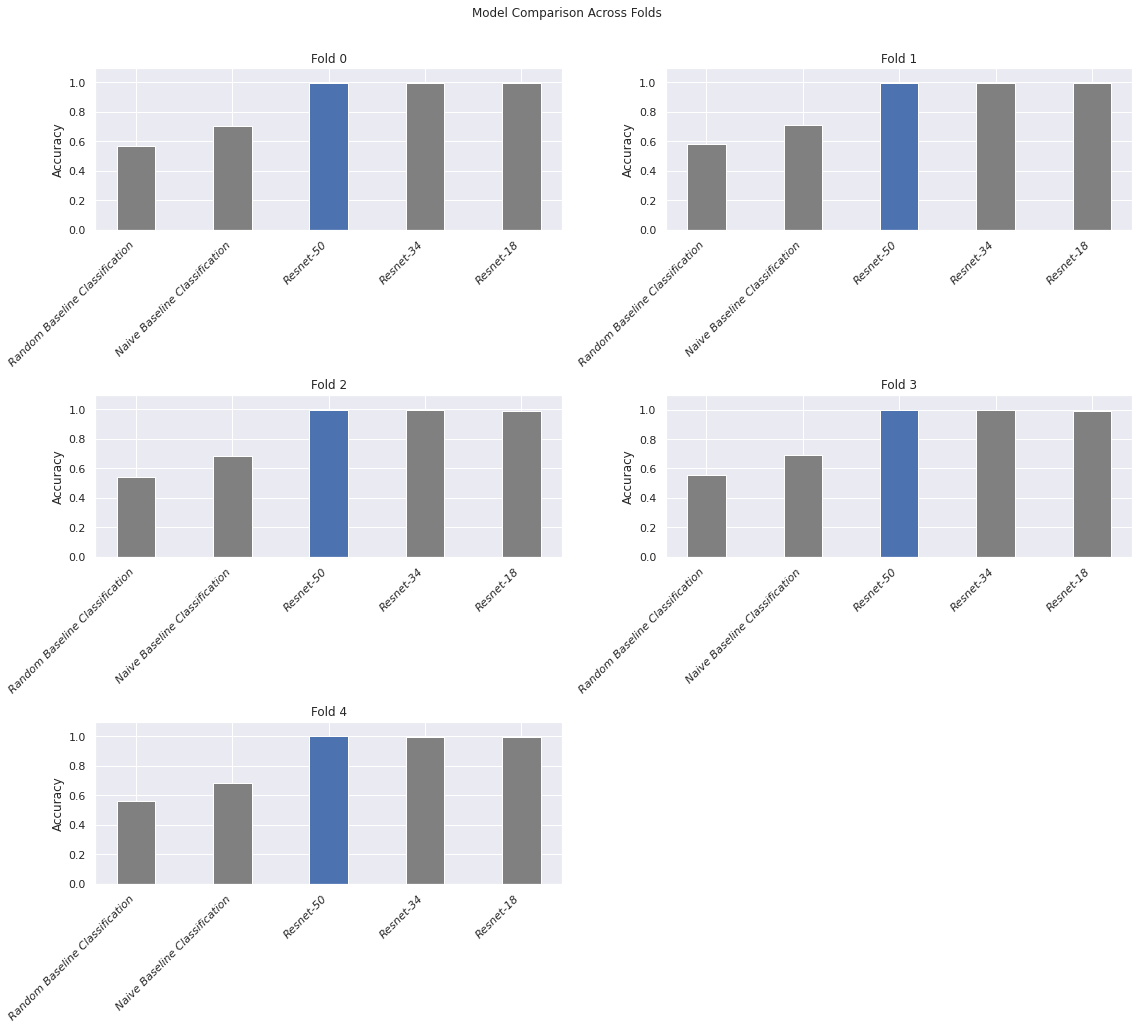

In [56]:
#_ = exp_mang.trainer.display_best_models()